# PL Cropping

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from frgpascal.analysis.processing import load_all
from natsort import index_natsorted

def load_all_sorted(chardir):
	metricdf, rawdf = load_all(
		chardir,
		t_kwargs=dict(
			wlmin=700,
			wlmax=900
		)
	)
	rawdf= rawdf.sort_values(
   		by='name',
   		key=lambda x: np.argsort(index_natsorted(rawdf['name']))
    )
	rawdf = rawdf.reset_index(drop=True)


	metricdf= metricdf.sort_values(
    	by='name',
    	key=lambda x: np.argsort(index_natsorted(metricdf['name']))
    )
	metricdf = metricdf.reset_index(drop=True)
	return metricdf, rawdf

In [3]:
# load the images
chardir = '../data/output/20221011_B9-char_1/Characterization/'
_, rawdf = load_all_sorted(chardir)

Loading data:   0%|          | 0/31 [00:00<?, ?sample/s]/home/kcw/anaconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:103: RuntimeWarning: invalid value encountered in log10
  a = -np.log10(t)
Loading data:  13%|█▎        | 4/31 [00:04<00:24,  1.09sample/s]/home/kcw/anaconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:103: RuntimeWarning: divide by zero encountered in log10
  a = -np.log10(t)
Loading data: 100%|██████████| 31/31 [00:27<00:00,  1.15sample/s]


In [4]:
rawdf = rawdf.reset_index().rename(columns={'index': 'sample_num'})

In [5]:
rawdf.head(1)

,sample_num,pl_0,t_0,df_0,bf_0,plimg_0,name
0,0,"{'wl': [178.95, 179.38, 179.8, 180.23, 180.65,...","{'wl': [179.38, 179.8, 180.23, 180.65, 181.08,...","[[[96.16787, 57.04131, 0.0], [96.99463, 56.334...","[[[0.6191406, 0.53027344, 0.6425781], [0.59277...","[[[0.81152344, 0.61328125, 0.0], [0.85058594, ...",sample0


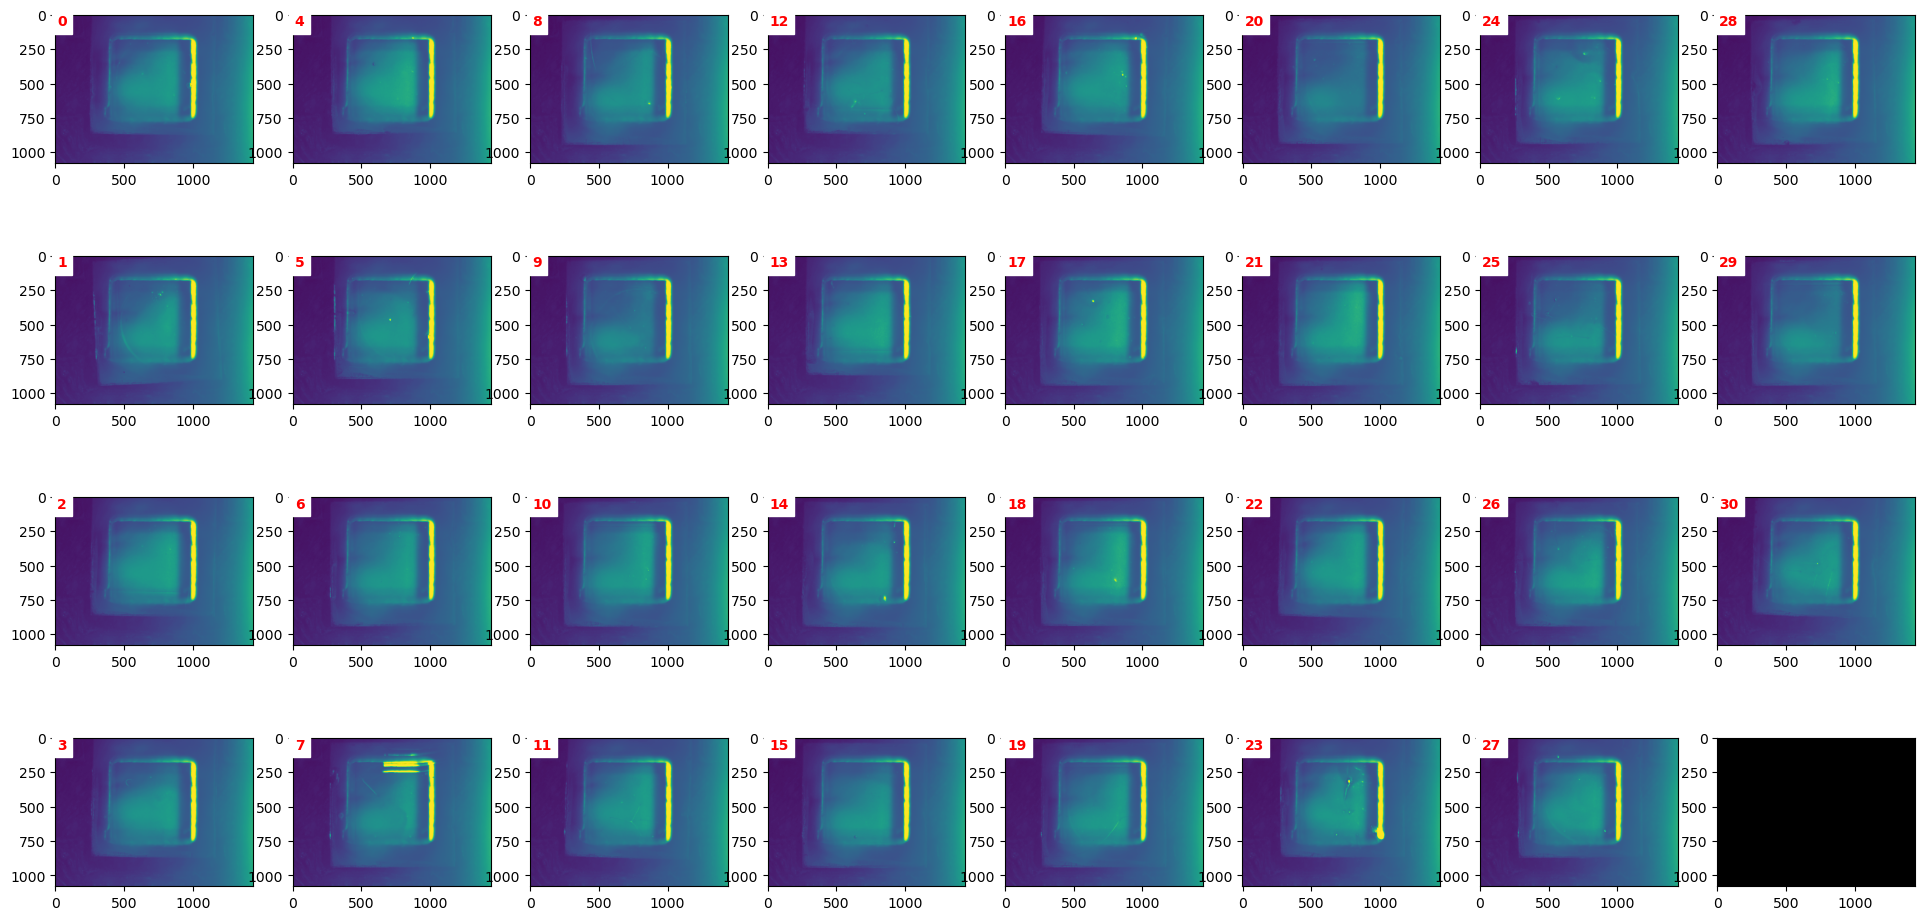

In [6]:
# view whole batch of df images

# now plot
blank = rawdf['df_0'].iloc[0]*0

vert = 4
horiz = 8
embiggen = 3
item = 0

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen), constrained_layout=False)

for k in range(horiz):
    for n in range(vert):
        try:
            img = np.uint8(rawdf['df_0'].iloc[item])
            ax[n,k].imshow(img[:,:,0])
            plt.text(0.01, 1, s = f'{rawdf["sample_num"].iloc[item]}', horizontalalignment='left', verticalalignment='top', transform=ax[n,k].transAxes, color='Red', weight='bold', backgroundcolor='White')
            
            
        except:
            ax[n,k].imshow(blank)
            
        
        item += 1

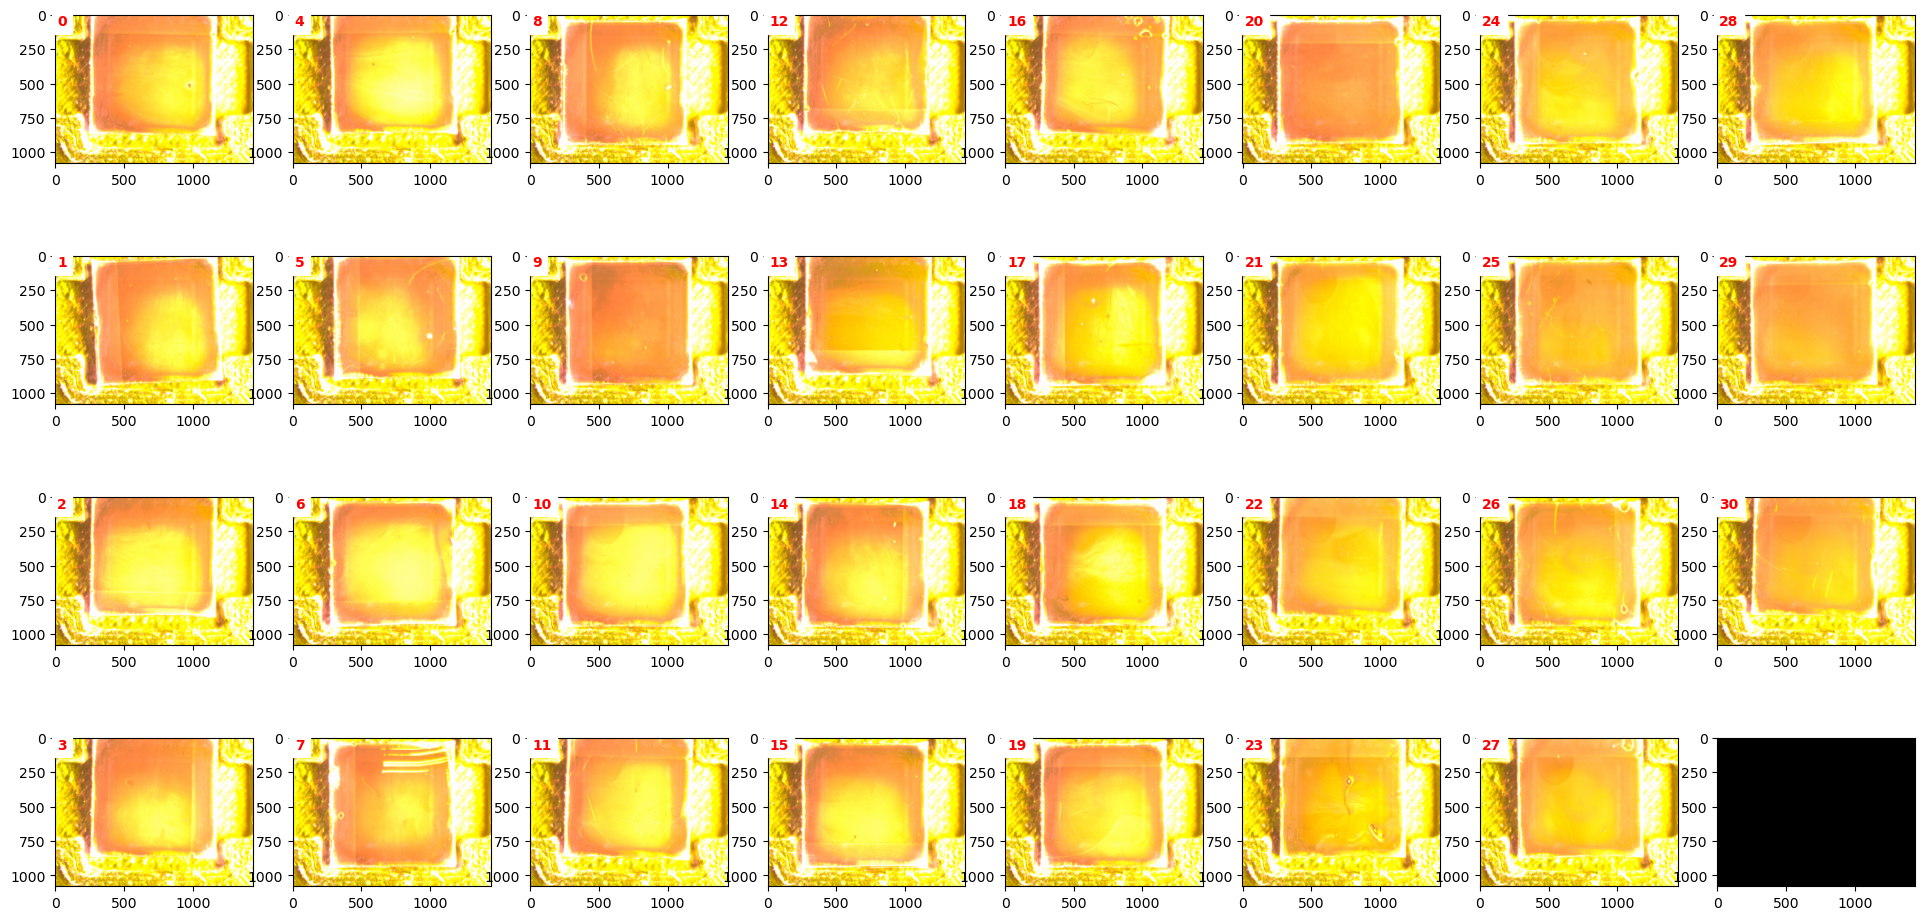

In [7]:
# view whole batch of pl images

# now plot
blank = rawdf['plimg_0'].iloc[0]*0

vert = 4
horiz = 8
embiggen = 3
item = 0

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen), constrained_layout=False)

for k in range(horiz):
    for n in range(vert):
        try:
            img = np.uint8(rawdf['plimg_0'].iloc[item] * 255)
            ax[n,k].imshow(img)
            plt.text(0.01, 1, s = f'{rawdf["sample_num"].iloc[item]}', horizontalalignment='left', verticalalignment='top', transform=ax[n,k].transAxes, color='Red', weight='bold', backgroundcolor='White')
            
        except:
            ax[n,k].imshow(blank)
            
        
        item += 1

7085.5 0
63798.0 7085.5
720743.0 63798.0
165854.0 720743.0


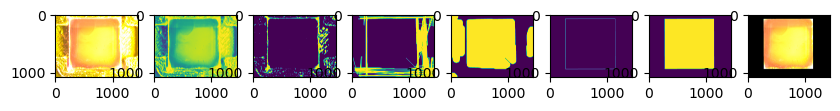

In [63]:
import cv2
import numpy as np

img = np.uint8(rawdf['plimg_0'].iloc[10] * 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
thresh = cv2.inRange(gray, 250, 256) # threshold on white, the border of sample

# use houghline transform to clean up and create border
minLineLength = thresh.shape[0]*0.03
maxLineGap = 200
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)
if lines is None:
    lines = np.zeros(0)
# print(lines.shape)

# now draw the lines
line_img = np.zeros_like(gray, np.uint8)
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.int32)
    x1, y1, x2, y2 = arr
    cv2.line(line_img, (x1, y1), (x2, y2), 255, 4)

# close in gaps to reduce noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,30))
filled = cv2.morphologyEx(line_img, cv2.MORPH_CLOSE, kernel, iterations=4)
filled = cv2.bitwise_not(filled)


# now get the bounding box of the largest area square, which is probably the sample
box_image = np.zeros_like(filled, np.uint8)
contours, _ = cv2.findContours(filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_rect = None
biggest_area = 0
for c in contours:
    # cv2.drawContours(final,[c],0,(0,0,0),2)
    # get rotated rectangle from contour
    rot_rect = cv2.minAreaRect(c)
    area = cv2.contourArea(c)

    print(area, biggest_area)
    if area > biggest_area:
        box = cv2.boxPoints(rot_rect)
        box = np.int0(box)
        biggest_rect = box
        biggest_area = area

# draw rectangle on img
cv2.drawContours(box_image,[biggest_rect],0,255,2)
final = box_image.copy()

# now floodfill to use as mask
h,w = final.shape
cv2.floodFill(final, np.zeros((h+2,w+2), np.uint8), (0,0), 255)
final = cv2.bitwise_not(final)

# now show mask
masked = cv2.bitwise_and(img, img, mask=final)

fig, ax = plt.subplots(1,8, figsize=(10,7))
ax = ax.flat
ax[0].imshow(img)
ax[1].imshow(gray)
ax[2].imshow(thresh)
ax[3].imshow(line_img)
ax[4].imshow(filled)
ax[5].imshow(box_image)
ax[6].imshow(final)
ax[7].imshow(masked)

In [66]:
def crop_pl(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.inRange(gray, 250, 256) # threshold on white, the border of sample

    # use houghline transform to clean up and create border
    minLineLength = thresh.shape[0]*0.03
    maxLineGap = 200
    lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)
    if lines is None:
        lines = np.zeros(0)

    # now draw the lines
    line_img = np.zeros_like(gray, np.uint8)
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.int32)
        x1, y1, x2, y2 = arr
        cv2.line(line_img, (x1, y1), (x2, y2), 255, 4)

    # close in gaps to reduce noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,30))
    filled = cv2.morphologyEx(line_img, cv2.MORPH_CLOSE, kernel, iterations=4)
    filled = cv2.bitwise_not(filled)

    # now get the bounding box of the largest area square, which is probably the sample
    box_image = np.zeros_like(filled, np.uint8)
    contours, _ = cv2.findContours(filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest_rect = None
    biggest_area = 0
    for c in contours:
        # cv2.drawContours(final,[c],0,(0,0,0),2)
        # get rotated rectangle from contour
        rot_rect = cv2.minAreaRect(c)
        area = cv2.contourArea(c)

        if area > biggest_area:
            box = cv2.boxPoints(rot_rect)
            box = np.int0(box)
            biggest_rect = box
            biggest_area = area

    # draw rectangle on img
    cv2.drawContours(box_image,[biggest_rect],0,255,2)
    final = box_image.copy()

    # now floodfill to use as mask
    h,w = final.shape
    cv2.floodFill(final, np.zeros((h+2,w+2), np.uint8), (0,0), 255)
    final = cv2.bitwise_not(final)

    # now show mask
    masked = cv2.bitwise_and(img, img, mask=final)

    return masked

# fig, ax = plt.subplots(1,6, figsize=(10,7))
# ax = ax.flat
# ax[0].imshow(img)
# ax[1].imshow(gray)
# ax[2].imshow(thresh)
# ax[4].imshow(line_img)
# # ax[5].imshow(dst)
# ax[5].imshow(r)
# ax[1].imshow(canny)

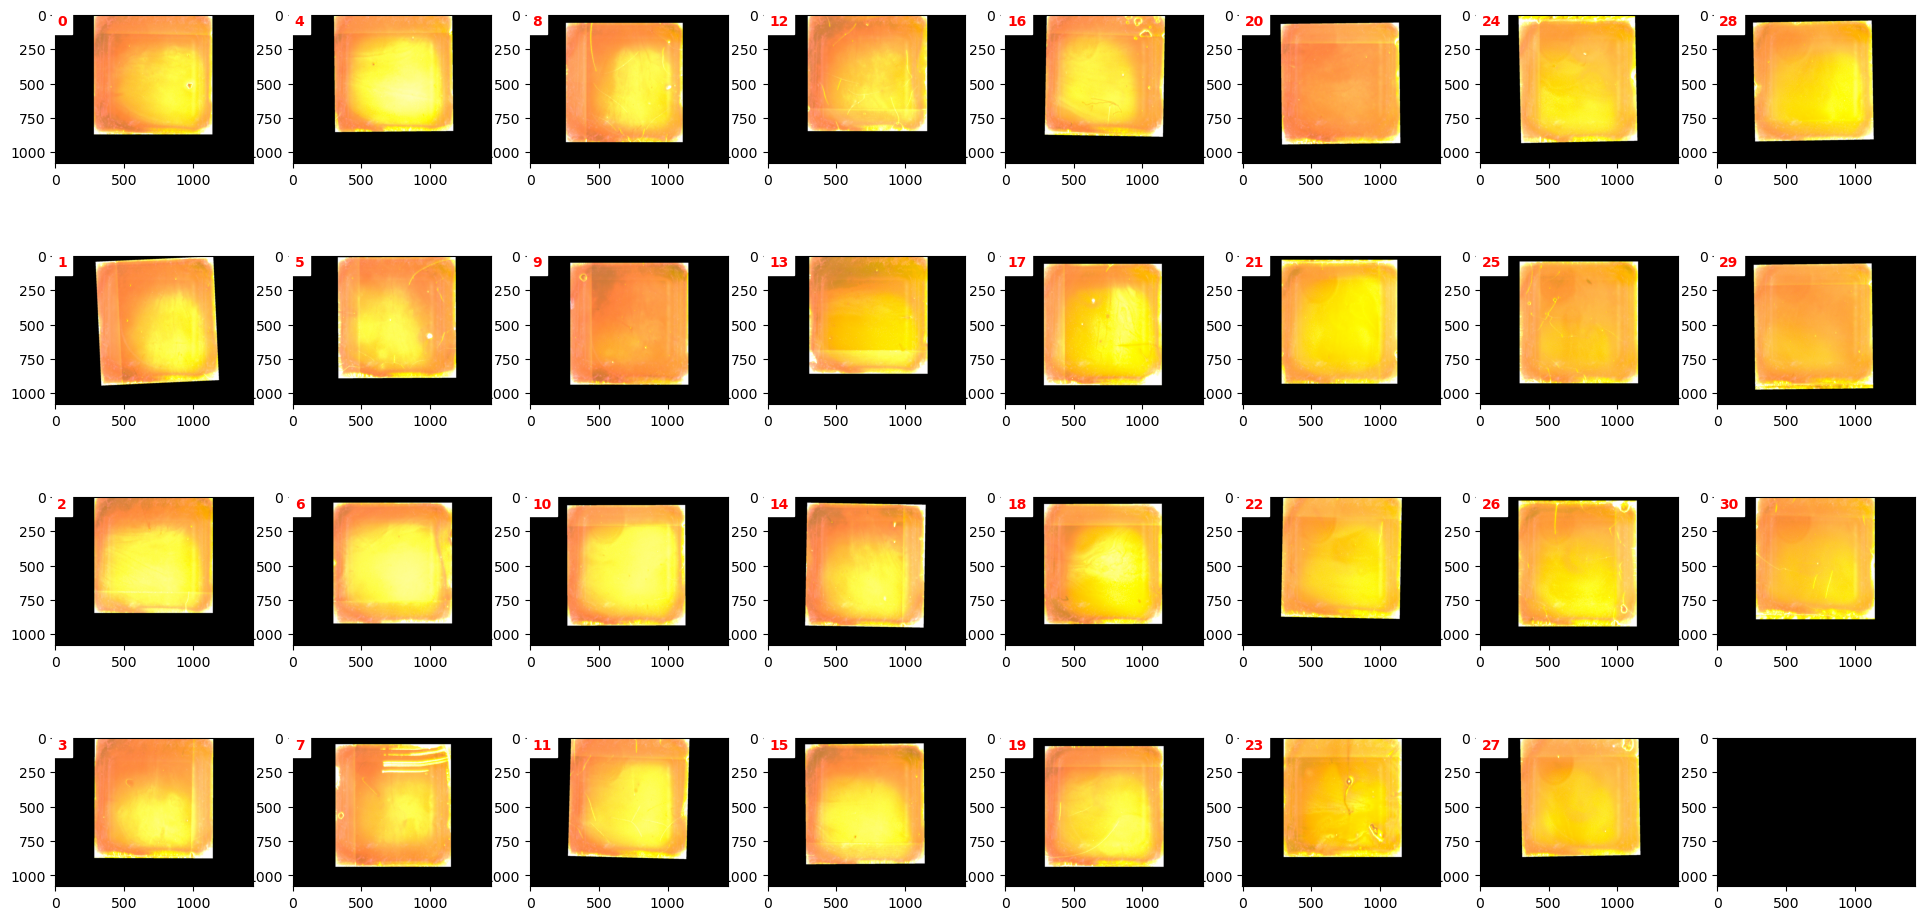

In [67]:
# view whole batch of pl images

# now plot
blank = rawdf['plimg_0'].iloc[0]*0

vert = 4
horiz = 8
embiggen = 3
item = 0

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen), constrained_layout=False)

for k in range(horiz):
    for n in range(vert):
        try:
            img = crop_pl(np.uint8(rawdf['plimg_0'].iloc[item] * 255))
            ax[n,k].imshow(img)
            plt.text(0.01, 1, s = f'{rawdf["sample_num"].iloc[item]}', horizontalalignment='left', verticalalignment='top', transform=ax[n,k].transAxes, color='Red', weight='bold', backgroundcolor='White')
            
        except:
            ax[n,k].imshow(blank)
            
        
        item += 1